# Steam games characteristics data analysis

**Authors:** Yitao Xu, Ruizhe Zhang, Wenxuan Li

## Introduction

The booming online gaming industry is a mutually beneficial ecosystem for entrepreneurs, players and gaming developers, providing them opportunities to satiate their lucrative appetite for online gaming. In a recent report by ResearchAndMarkets, the global gaming market was valued at USD 174 billion in 2020, and it is expected to reach a value of USD 314 billion by 2026, registering a CAGR of 9.64% over 2021-2026. As the group members all share an interest in games, we choose the games and their performances on Steam, the largest digital distribution platform for PC gaming, as our topic. 

### What we did in this project
+ We went through the basic process of data analysis and explored the data of 10000+ games on Steam
+ We explored and visualized the perspectives such as the distributions of game genres, developers, categories and prices
+ We tried to answer what characteristics made a game more favorable among players

## Dataset

For this project, by getting the .json format data in the API, reading it in the notebook and transferring it into a pandas DataFrame, we got the initial dataset, which has 10210 rows and 10 columns. Since in this API only the data of games with marketable trading items is included and the official steam API does not provide data that we want to study, we decided to focus on these 10210 games.

### Information:
**Name:** processed_data.csv  
**Data source:** Process of raw data from the subscribeable API "SteamApi"  
**Links:**  
+ SteamApi: https://steamapis.com/  
+ Details of processing raw data: making_data.ipynb in https://github.com/AmayaXu/4003GroupProject  

### Attributes:
+ **Appid:** the unique id of the game
+ **Game name:** the full name of the game
+ **Release Date:** the game's release date
+ **Coming soon:** whether the game is coming soon
+ **Initial price:** the game's price when it was first released
+ **Final price:** the game's current price
+ **Developer:** developer(s) of the game
+ **Category:** categories the game belongs to(single-player, multi-player, PvP, etc.)
+ **Genre:** the genres of the game(Action, Adventure, RPG, etc.) 
+ **Recommendations:** the number of the game's recommendations

## Data prepocessing

In this section, we will look at the actual data closely and preprocess the data for our analysis and modeling.

First we imported some libraries we will need below.

In [1]:
import pandas as pd
import matplotlib
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import seaborn as sns
from functools import reduce
import plotly.graph_objects as go
from plotly.subplots import make_subplots

%matplotlib inline

# configure seaborn to our liking
sns.set_style('darkgrid', {"axes.facecolor": ".95", "axes.edgecolor": "black", "xtick.bottom": "True", \
                           "ytick.left": "True", 'patch.force_edgecolor': False})
sns.set_context("notebook")
sns.set_palette(["#28abe3", "#db3340", "#e8b71a", "#1fda9a", "#f7eac8"])
blend_palette = sns.diverging_palette(258, 12, sep=20, as_cmap=True)

Then we read the .csv file to transfer the data into an easy-to-manipulate DataFrame and dropped all rows with **None** and with repeated **Appid**:

In [2]:
data = pd.read_csv("processed_data.csv").drop(columns=["Unnamed: 0"])
data = data.drop_duplicates(["Appid"])
data = data.dropna()

In [3]:
# A random example of data before cleaning
data.loc[4468]

Appid                                                         105600
Game name                                                   Terraria
Release date                                            May 16, 2011
Coming soon                                                    False
Initial price                                                   9.99
Final price                                                     9.99
Developer                                                   Re-Logic
Category           Single-player, Multi-player, PvP, Online PvP, ...
Genre                                  Action, Adventure, Indie, RPG
Recommendations                                               457853
Name: 4468, dtype: object

### Date formatting

As shown in the example above, **Release date** is not the standard datetime format. In order to make the data easy to analyze, we changed it into the format "YYYY-MM-DD" using the code below:

In [4]:
# Clean date
date = data['Release date'].str.split(',', expand=True)
date["Appid"]=data["Appid"]
date2 = date[0].str.split(' ', expand=True)
date[2] = date2[0]
date[3] = date2[1]
date = date.drop(0, axis=1)
date = date.dropna()
date[1] = date[1].astype('int64')
date[3] = date[3].astype('int64')
date[2] = pd.to_datetime(date[2], format='%b').dt.month
date=date.rename(columns={1:"Year",2:"Month",3:"Day"})
date["Date"] = pd.to_datetime(date[["Year","Month","Day"]])
date = date.drop(["Year","Month","Day"],axis=1).reset_index().drop("index",axis=1)
date = date.set_index("Appid")
data = data.join(date,on="Appid")
data = data.drop(columns = ["Release date"])

### Column Selection

For each single game, there may be more than one item in **Genre**, **Catgory**, and **Developer**. In order to make these contents easy to aggregate and analyze, what we did below was to split each of these three columns. 

For **Genre**, we transferred it to 11 columns **Genre1**-**Genre11**, sequentially putting one genre in one column. 

For **Category**, we used the 8 categories as column names, and the value for a specific category equals 1 if the game belongs to it and equals 0 otherwise. The categories are defined as follows:
+ **Single-player**: Game that can be played by one person
+ **Multi-player**: Game that can be played by several players
+ **Co-op**: Game that requires players working with one another to achieve a common objective
+ **MMO**: Massively multiplayer online game
+ **PvP**: Player versus player
+ **VR Support**: Game with VR technology
+ **Remote Play on Phone**: Game that can be played on a smartphone device
+ **Steam Achievements**: Game that have achievement trackings,which is displayed on the Steam community profile

The process of **Developer** is similar to that of **Genre**, splitting it into **Developer Major** and **Developer 2**. 

Besides, we also added another two columns **Genre Count** and **Developer Count** to show the number of genres and developers.

In [5]:
## Split Genre into columns
data = data[data["Genre"] != "None"]
Genre_Columns = []
for i in range(1,12):
    Genre_Columns.append("Genre"+str(i))
    
data[Genre_Columns] = data['Genre'].str.split(", ", 10, expand=True)
data["Genre Count"] = data['Genre'].str.count(", ") + 1 

In [6]:
## Split Category into columns (7)
Category_Columns = ["Single-player", "Multi-player", "Co-op", "MMO", "VR Support", "PvP", "Remote Play on Phone","Steam Achievements"]

for i in Category_Columns:
    data[i] = data["Category"].str.contains(str(i), na=True)
    data[i] = data[i].astype(int)

In [7]:
## Split Developers into columns (2)
data[["Developer Major","Developer 2","Others"]] = data['Developer'].str.split(", ", 2, expand=True)
data["Developer Count"] = data['Developer'].str.count(", ") + 1 

Finally, after dropping all unnecessary columns, we got the data used for the following analysis and visualization:  

In [8]:
# Data after cleaning
data = data[['Appid','Game name','Date','Coming soon','Initial price','Final price','Genre','Recommendations',
 'Genre1','Genre2','Genre3','Genre4','Genre5','Genre6','Genre7','Genre8','Genre9','Genre10','Genre11','Genre Count',
 'Single-player','Multi-player','Co-op','MMO','PvP','VR Support','Remote Play on Phone',"Steam Achievements",
 'Developer Major','Developer 2','Developer Count']]
data.loc[4668]

Appid                                            234650
Game name                             Shadowrun Returns
Date                                2013-07-25 00:00:00
Coming soon                                       False
Initial price                                     14.99
Final price                                       14.99
Genre                   Adventure, Indie, RPG, Strategy
Recommendations                                    7930
Genre1                                        Adventure
Genre2                                            Indie
Genre3                                              RPG
Genre4                                         Strategy
Genre5                                             None
Genre6                                             None
Genre7                                             None
Genre8                                             None
Genre9                                             None
Genre10                                         

## Data analysis and visualization

In this section, we will review and visualize our data in order to understand the data better. Our data exploration and analysis will help us study the topics we are interested in.

Let pandas describe the dataset for more insight.

In [9]:
## Data Description
print('The shape of the cleaned dataset is {}.'.format(data.shape))
pd.options.display.float_format = '{:,.2f}'.format
data[["Recommendations","Initial price","Final price","Developer Count","Genre Count"]].describe()

The shape of the cleaned dataset is (10124, 31).


,Recommendations,Initial price,Final price,Developer Count,Genre Count
count,"10,124.00","10,124.00","10,124.00","10,124.00","10,124.00"
mean,"2,587.30",9.80,10.35,1.13,2.79
std,"34,665.57",10.22,10.39,0.43,1.22
min,0.00,0.00,0.00,1.00,1.00
25%,0.00,2.99,2.99,1.00,2.00
50%,147.00,6.99,7.99,1.00,3.00
75%,583.00,14.99,14.99,1.00,3.00
max,"2,850,475.00",199.99,199.99,7.00,11.00


On average, a game will have 2587 recommendations, a initial price of 9.8(USD) and a final price of 10.4(USD). There would usually be no more than 1 game developer and approximately 3 genres presenting in a game.

The data discription also shows strong dispersion in recommendation and prices. The standard deviation of recommendations is especially high. It's also surprising that 25% of the total games do not even have a recommendation.

On the contrary,the number of developers and genres are concentrating around the mean value. More than 75% of the games have only one developer, and can be characterised by 3 genres.

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
data[Category_Columns].describe()

,Single-player,Multi-player,Co-op,MMO,VR Support,PvP,Remote Play on Phone,Steam Achievements
count,"10,124.00","10,124.00","10,124.00","10,124.00","10,124.00","10,124.00","10,124.00","10,124.00"
mean,0.95,0.27,0.14,0.02,0.01,0.14,0.03,0.77
std,0.22,0.44,0.34,0.15,0.10,0.35,0.18,0.42
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


Concerning the surging socializing need for games, we selected the catagories representing the participation form of players. The statistic description shows that 95% of the games are single player games, while 27% can be played by multiple players. This implies that the majority(73%) of the games on Steam are only designed for single player. Among multi-player games, Co-op games and PvP games both account for 14% of the total games, while MMO games only account for 2% of the total games.

Concerning the recent technology trends, we want to explore the appication progress of VR and mobile gaming support. The now affordable and portable VR technology is applied in the game industry since 2016(release of PlaystationVR). Since then, developers have been trying to design games with VR experiences. Until now, approximately 1% of the games support VR, which can be viewed as a huge progress concerning the difficulty and input in developing VR games. Although mobile gaming are expanding the size and profit, the Steam platform only has 3% of games supporting remote play on smartphones, which not surprisingly shows a lack of competence of Steam in the mobile platform.

### Recommendation

As we are trying to answer what characteristics make the game favorable among players, we first take a glance at the recommendation distribution and the characteristics of the most recommended games:

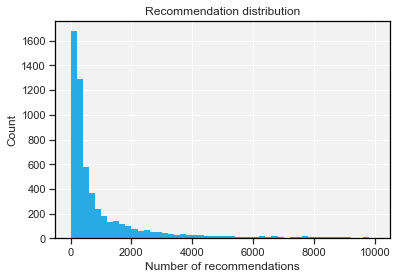

In [11]:
plt.hist(data[data["Recommendations"]>0]["Recommendations"],bins=50,range=(1,10000))
plt.xlabel('Number of recommendations')
plt.ylabel('Count')
plt.title('Recommendation distribution')
plt.show()

In [12]:
## Most Recommended
Recommend_stat = data[["Appid","Game name","Recommendations", "Date", "Final price","Genre"]].sort_values(by=["Recommendations"],ascending=False)
Recommend_stat.head(10)

,Appid,Game name,Recommendations,Date,Final price,Genre
3456,730,Counter-Strike: Global Offensive,2850475,2012-08-21,14.99,"Action, Free to Play"
2214,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,1295198,2017-12-21,29.99,"Action, Adventure, Massively Multiplayer"
117,359550,Tom Clancy's Rainbow Six® Siege,622678,2015-12-01,19.99,Action
1060,4000,Garry's Mod,503430,2006-11-29,9.99,"Indie, Simulation"
4468,105600,Terraria,457853,2011-05-16,9.99,"Action, Adventure, Indie, RPG"
3234,292030,The Witcher® 3: Wild Hunt,376029,2015-05-18,39.99,RPG
7487,252490,Rust,367337,2018-02-08,39.99,"Action, Adventure, Indie, Massively Multiplaye..."
50,252950,Rocket League®,333485,2015-07-07,19.99,"Action, Indie, Racing, Sports"
9406,346110,ARK: Survival Evolved,284600,2017-08-27,49.99,"Action, Adventure, Indie, Massively Multiplaye..."
42,218620,PAYDAY 2,279911,2013-08-13,9.99,"Action, RPG"


Noticing that the recommendation distribution is highly skewed with a large spread, the majority of games have very low recommendations, while a small number of games dominate the market.The Top10 games are showing common genre in Action(8/10), RPG(5/10) and Adventure(4/10).

To further compare the subgroup of top recommended games and the complete set, we again look into the statistic descriptions.

Compared to the whole dataset, the top 100 most recommended games have an overall higher price(26 𝑣𝑠 10), more developers(1.5 vs 1.1) and more focued genres(2.3 vs 2.9). Also, people are more likely to prefer games with Multi-player, Co-op and PvP modes compared to those merely single-player games. The features of remote play on phone is also preferred.

In [13]:
## Characteristic of the recommended (100)
Recommend = data.sort_values(by=["Recommendations"],ascending=False).head(100)

## Data Description of recommended games(top 100)
pd.options.display.float_format = '{:,.2f}'.format
Recommend[["Recommendations","Initial price","Final price","Developer Count","Genre Count"]].describe()

,Recommendations,Initial price,Final price,Developer Count,Genre Count
count,100.00,100.00,100.00,100.00,100.00
mean,"150,839.08",25.64,26.64,1.49,2.32
std,"314,897.10",16.21,15.44,1.13,1.22
min,"41,423.00",0.00,0.00,1.00,1.00
25%,"50,127.50",14.99,14.99,1.00,1.00
50%,"69,075.00",19.99,19.99,1.00,2.00
75%,"128,463.75",29.99,29.99,1.00,3.00
max,"2,850,475.00",59.99,59.99,7.00,7.00


In [14]:
## Category Data Description of recommended games(top 100)
pd.options.display.float_format = '{:,.2f}'.format
Recommend[Category_Columns].describe()

,Single-player,Multi-player,Co-op,MMO,VR Support,PvP,Remote Play on Phone,Steam Achievements
count,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
mean,0.86,0.61,0.42,0.04,0.01,0.28,0.39,0.86
std,0.35,0.49,0.50,0.20,0.10,0.45,0.49,0.35
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
50%,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00
75%,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Release Date

Firstly, we got some critical information about the games' release time, including the first and the last games' release date and the number of coming-soon games: 


In [15]:
print('Our first game was released on {} (min value).'.format(data.Date.min().strftime("%d. %B %Y")))
print('Our last game was released on {} (max value).'.format(data.Date.max().strftime("%d. %B %Y")))
print('{} games are planning to release in the future.'.format(len(data[data["Coming soon"] == True])))

Our first game was released on 30. June 1997 (min value).
Our last game was released on 01. January 2021 (max value).
32 games are planning to release in the future.


<i>Although there are games released between 1 Jan 2021 and the current date, the release date recorded in the data set is ambiguous(eg. 2021 Fall). In this case we only count games with exact release dates</i>

Then, we drew a histogram showing the time distribution of all games:

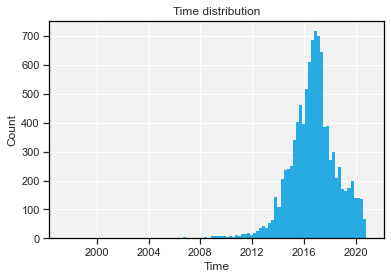

In [16]:
plt.hist(data['Date'], bins=100)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Time distribution')

plt.show()

From the histogram, the number of released games with tradable items increases fast since **2012**, reaches the highest point around **2017**, and then decreases drastically. 

The increasing trend is easy to understand, but what confuses us is the huge fall after 2017. One possible reason that we could think of is that the market for traded item is broken, making the in-game trading unprofitable for developers and unnecessary for gamers, and this guess is proved by an online article "Why the Ingame Items Market is Broken: a Gamer’s and Trader’s Perspective on Trading Inefficiencies" published in 2019, which explains the difficulties and inefficiencies in game trading that make the in-game trading market crash. (Site: https://f1pme.medium.com/why-the-ingame-items-market-is-broken-a-gamers-and-trader-s-perspective-on-trading-inefficiencies-577d3a9f7fde)

Next, in order to get more useful information from release time, we had the month distribution of games:

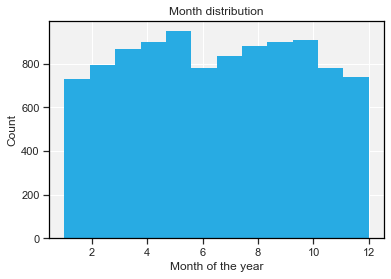

In [17]:
months = data['Date'].map(lambda t: t.month)

plt.hist(months, bins=12)
plt.xlabel('Month of the year')
plt.ylabel('Count')
plt.title('Month distribution')

plt.show()

The histogram of month distribution shows that larger number of games were released around **May** and **October** than on other months, which is predictable from the reality. 

There are two important world-wide gaming show annually: E3, GC, and TGS. Usually E3 starts around May and June, while GC and TGS are held around September and October. In order to attract people's attention on the show, many game developers choose to release many of their games around these two periods. At other times, the developers begin to design new games and prepare for the next show, only those unfamous Indie game developers not caring about the show release new games. 

This perfectly explains why the number of released games decreases significantly after May and October.

Finally, we had the distribution of week days on which games were released:

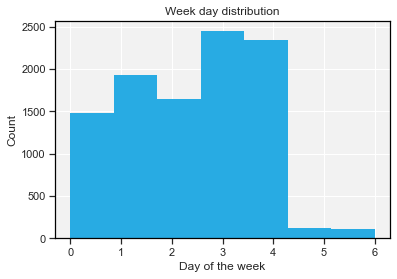

In [18]:
# 0: Monday, 6: Sunday
week_days = data['Date'].map(lambda t: t.weekday())

plt.hist(week_days, bins=7)
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.title('Week day distribution')

plt.show()

From the distribution, most games were released on **Thursday** and **Friday**, while very few games were released on weekends. Thursday and Friday are perfect for releasing games because they are close to the weekend, and it is easier for game fanatics to notice, purchase, and play games. So it is understandable that game developers choose to compete on these two days. 

The reason why few games were released on weekends is also obvious: at the precious rest time, gamers prefer playing their purchased games to wasting time on finding new games. Therefore, fewer people will notice games released on the weekend, making the game less profitable.

### Genre

Firstly, we showed the distribution of the number of genres for each game:

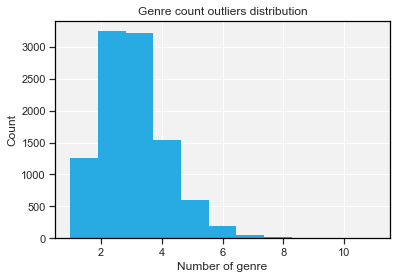

In [19]:
plt.hist(data["Genre Count"],bins=11)
plt.xlabel('Number of genre')
plt.ylabel('Count')
plt.title('Genre count outliers distribution')
plt.show()

Apparently, most of the games have two or three genres, and very few games have more than six genres. Since most of the games in our own game libraries also have two or three genres, the result is consistent with the reality.  
  
Next, for each genre we will count the number of games, sum up the total number of recommendations, and calculate the average number of recommendations. We do this in order to study the most popular and least popular genres. Also, in order to show the result intuitively, we use plotly to draw pie charts for each of the three groups of data.

In [20]:
## Genre count and percentage
append_genre = pd.Series(dtype=str)
for i in Genre_Columns:
    append_genre = append_genre.append(data[i])
Unique_genre = append_genre.unique()
Genre_stat = pd.DataFrame(append_genre.value_counts(),columns=["Count"])
Genre_stat["%"] = Genre_stat["Count"]/sum(Genre_stat["Count"])*100

## Recommendation sum of each genre
df1 = data[["Genre1","Recommendations"]].groupby(by="Genre1").sum().reset_index().rename(columns= {"Genre1":"Genre","Recommendations":"R1"}) 
df2 = data[["Genre2","Recommendations"]].groupby(by="Genre2").sum().reset_index().rename(columns= {"Genre2":"Genre","Recommendations":"R2"})
df3 = data[["Genre3","Recommendations"]].groupby(by="Genre3").sum().reset_index().rename(columns= {"Genre3":"Genre","Recommendations":"R3"})
df4 = data[["Genre4","Recommendations"]].groupby(by="Genre4").sum().reset_index().rename(columns= {"Genre4":"Genre","Recommendations":"R4"})
df5 = data[["Genre5","Recommendations"]].groupby(by="Genre5").sum().reset_index().rename(columns= {"Genre5":"Genre","Recommendations":"R5"})
df6 = data[["Genre6","Recommendations"]].groupby(by="Genre6").sum().reset_index().rename(columns= {"Genre6":"Genre","Recommendations":"R6"})
df7 = data[["Genre7","Recommendations"]].groupby(by="Genre7").sum().reset_index().rename(columns= {"Genre7":"Genre","Recommendations":"R7"})
df8 = data[["Genre8","Recommendations"]].groupby(by="Genre8").sum().reset_index().rename(columns= {"Genre8":"Genre","Recommendations":"R8"})
df9 = data[["Genre9","Recommendations"]].groupby(by="Genre9").sum().reset_index().rename(columns= {"Genre9":"Genre","Recommendations":"R9"})
df10 = data[["Genre10","Recommendations"]].groupby(by="Genre10").sum().reset_index().rename(columns= {"Genre10":"Genre","Recommendations":"R10"})
df11 = data[["Genre11","Recommendations"]].groupby(by="Genre11").sum().reset_index().rename(columns= {"Genre11":"Genre","Recommendations":"R11"})

recom_by_genre = reduce(lambda  left,right: pd.merge(left,right,on=['Genre'],how='outer'), [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11])
recom_by_genre = recom_by_genre.fillna(0)
recom_by_genre["Total recommendations"] = recom_by_genre["R1"]+recom_by_genre["R2"]+recom_by_genre["R3"]+recom_by_genre["R4"]+recom_by_genre["R5"]+recom_by_genre["R6"]+recom_by_genre["R7"]+recom_by_genre["R8"]+recom_by_genre["R9"]+recom_by_genre["R10"]+recom_by_genre["R11"]
total_recom_by_genre = recom_by_genre[["Genre","Total recommendations"]]
total_recom_by_genre = total_recom_by_genre.sort_values(by="Total recommendations", ascending=False).reset_index().drop("index",axis=1)
total_recom_by_genre = total_recom_by_genre.set_index("Genre")
Genre_stat = Genre_stat.join(total_recom_by_genre)
Genre_stat["Recommendation %"] = Genre_stat["Total recommendations"]/sum(Genre_stat["Total recommendations"])*100

## Average recommendation for each genre
Genre_stat["Average Recommendation"] = round(Genre_stat["Total recommendations"]/Genre_stat["Count"],0)
Genre_stat["Average Recommendation %"] = Genre_stat["Average Recommendation"]/sum(Genre_stat["Average Recommendation"])*100

Genre_stat

,Count,%,Total recommendations,Recommendation %,Average Recommendation,Average Recommendation %
Indie,7496,26.53,"10,552,382.00",16.32,"1,408.00",1.23
Action,4791,16.95,"17,611,594.00",27.24,"3,676.00",3.21
Adventure,4274,15.12,"9,548,637.00",14.77,"2,234.00",1.95
Casual,3379,11.96,"2,212,479.00",3.42,655.00,0.57
Strategy,2147,7.60,"4,150,542.00",6.42,"1,933.00",1.69
RPG,2055,7.27,"6,463,734.00",10.00,"3,145.00",2.74
Simulation,1710,6.05,"4,741,217.00",7.33,"2,773.00",2.42
Early Access,498,1.76,"510,639.00",0.79,"1,025.00",0.89
Free to Play,475,1.68,"3,666,340.00",5.67,"7,719.00",6.73
Sports,348,1.23,"638,325.00",0.99,"1,834.00",1.60


In [21]:
labels = list(Genre_stat.index)
count = list(Genre_stat.Count)
total_r = list(Genre_stat["Total recommendations"])
avg_r = list(Genre_stat["Average Recommendation"])

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=count, name="Genre Count"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=total_r, name="Total recommendations"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=avg_r, name="Average Recommendation"),
              1, 3)
                        
# Use `hole` to create a donut-like pie chart
fig.update_traces(hole=.5, textposition='inside', hoverinfo="label+percent+value",textinfo='value')

fig.update_layout(
    title_text="Count and Recommendation by Genre of Games",
    uniformtext_minsize=12, uniformtext_mode='hide',
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Count', x=0.11, y=0.5, font_size=14, showarrow=False),
                 dict(text='Recommend', x=0.5, y=0.5, font_size=14, showarrow=False),
                 dict(text='Average', x=0.9, y=0.53, font_size=14, showarrow=False),
                 dict(text='Recommend', x=0.92, y=0.48, font_size=14, showarrow=False)])
fig.show()

The results show that Indie games have the largest number, and Action games have the most total recommendations. Besides, the top 3 of both count and total recommendation are three major genres in Steam: Indie, Action and Adventure. 

It seems that the most popular genre should be one of these three, but the chart for average recommendations gives us a totally different result: the top 4 are even not the game! These four genres are all tools and software which are used instead of being played. By checking the number of recommendtions of each game in these four genres, we can easily find the reason for high average recommendations: an app called Wallpaper Engine, in which people can design, use and share self-made wallpapers. Belonging to all these genres, it has 206425 recommendation, which is at the 15th position among all games. With the small number of games in these genres, Wallpaper Engine drastically elevated their average recommendations. It is wise for the developer to publish such a software on a platform with numerous fanatics of games and animes. For other "playable" games, the most prevalent genre(the one with the highest average recommendations) is Massively Multiplayer, which can be easily explained by the extremely high popularity of H1Z1 and PUBG.

There are also four genres that even don't have one single recommendation: Education, Episodic, Software training, and Short, which means that they are the least popular genres. A reasonable explanation is that, in contrast to Wallpaper Engine, these games or softwares' developers chose an inappropriate publishing platform. In other words, no one likes to watch series or learn how to code on steam: why doesn't he/she choose better platforms like Youtube or Udemy?

### Developer

The mean is 1.13 with a standard deviation of 0.43.


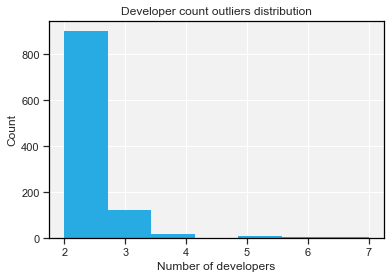

In [22]:
print('The mean is {:0.2f} with a standard deviation of {:0.2f}.'\
      .format(data["Developer Count"].mean(),data["Developer Count"].std()))

plt.hist(data[data["Developer Count"] > 1]["Developer Count"],bins=7)
plt.xlabel('Number of developers')
plt.ylabel('Count')
plt.title('Developer count outliers distribution')
plt.show()

In [23]:
## Developer count and percentage
append_developer = data["Developer Major"].append(data["Developer 2"])
Unique_developer = append_developer.unique()
Developer_stat = pd.DataFrame(append_developer.value_counts(),columns=["Count"])
Developer_stat = Developer_stat.drop(labels=["Inc.","LLC","Ltd.","LTD.","Feral Interactive (Linux)"])
Developer_stat["%"] = round(Developer_stat["Count"]/sum(Developer_stat["Count"])*100,2)

## Recommendation sum of each developer
df1 = data[["Developer Major","Recommendations"]].groupby(by="Developer Major").sum().reset_index().rename(columns= {"Developer Major":"Developer","Recommendations":"R1"}) 
df2 = data[["Developer 2","Recommendations"]].groupby(by="Developer 2").sum().reset_index().rename(columns= {"Developer 2":"Developer","Recommendations":"R2"})
recom_by_dvlpr = reduce(lambda  left,right: pd.merge(left,right,on=['Developer'],how='outer'), [df1,df2])
recom_by_dvlpr = recom_by_dvlpr.fillna(0)
recom_by_dvlpr["Total recommendations"] = recom_by_dvlpr["R1"]+recom_by_dvlpr["R2"]
total_recom_by_dvlpr = recom_by_dvlpr[["Developer","Total recommendations"]]
total_recom_by_dvlpr = total_recom_by_dvlpr.sort_values(by="Total recommendations", ascending=False).reset_index().drop("index",axis=1)
total_recom_by_dvlpr = total_recom_by_dvlpr.set_index("Developer")
Developer_stat = Developer_stat.join(total_recom_by_dvlpr)
Developer_stat["Recommendation %"] = round(Developer_stat["Total recommendations"]/sum(Developer_stat["Total recommendations"])*100,2)

## Average recommendation for each developer
Developer_stat["Average Recommendation"] = round(Developer_stat["Total recommendations"]/Developer_stat["Count"],0)
Developer_stat["Average Recommendation ‱"] = Developer_stat["Average Recommendation"]/sum(Developer_stat["Average Recommendation"])*10000

Developer_stat

,Count,%,Total recommendations,Recommendation %,Average Recommendation,Average Recommendation ‱
Square Enix,33,0.30,"138,596.00",0.43,"4,200.00",2.80
EnsenaSoft,32,0.29,824.00,0.00,26.00,0.02
Warfare Studios,29,0.27,714.00,0.00,25.00,0.02
Alawar Entertainment,29,0.27,"2,486.00",0.01,86.00,0.06
Winged Cloud,27,0.25,"13,853.00",0.04,513.00,0.34
...,...,...,...,...,...,...
Soap Interactive,1,0.01,0.00,0.00,0.00,0.00
ImCyan,1,0.01,0.00,0.00,0.00,0.00
DOG HOGGLER,1,0.01,0.00,0.00,0.00,0.00
橙光游戏,1,0.01,249.00,0.00,249.00,0.17


In order to explor the performance of the game developers on Steam, we kept focusing on the game count and recommendation data. From the chart above, we can see that the top five developers with the most games developed do not generate comparable recommendation results. To better view the top performancers, we selected the Top20 developers in each data point and create a series of bar charts below:

In [24]:
Dev_c = Developer_stat.sort_values(by="Count", ascending=False)[:20]
Dev_t = Developer_stat.sort_values(by="Total recommendations", ascending=False)[:20]
Dev_a = Developer_stat.sort_values(by="Average Recommendation", ascending=False)[:20]

labels_c = list(Dev_c.index)
labels_t = list(Dev_t.index)
labels_a = list(Dev_a.index)
count = Dev_c["Count"]
total_r = Dev_t["Total recommendations"]
avg_r = Dev_a["Average Recommendation"]

fig = make_subplots(rows=1, cols=3, specs=[[{}, {}, {}]], vertical_spacing=0.01, horizontal_spacing=0.23)
fig.add_trace(go.Bar(y=labels_c, x=count, orientation='h',text=count,name="Developer Count"),
              1, 1)
fig.add_trace(go.Bar(y=labels_t, x=total_r, orientation='h',text=total_r, name="Total recommendations"),
              1, 2)
fig.add_trace(go.Bar(y=labels_a, x=avg_r, orientation='h',text=avg_r, name="Average Recommendation"),
              1, 3)

fig.update_layout(
    title_text="Count and Recommendation by Developer of Games",
    uniformtext_minsize=2,uniformtext_mode='hide',legend_orientation="h")
fig.show()

In [25]:
print("Developers with both high numbers of released games and total recommendations: ", set(labels_c).intersection(labels_t))
print("Developers with both high numbers of released games and average recommendations: ", set(labels_c).intersection(labels_a))
print("Developers with both high numbers of total and average recommendations: ",set(labels_t).intersection(labels_a))

Developers with both high numbers of released games and total recommendations:  {'Feral Interactive (Mac)'}
Developers with both high numbers of released games and average recommendations:  set()
Developers with both high numbers of total and average recommendations:  {'Ubisoft Montreal', 'Re-Logic', 'Valve', 'CD PROJEKT RED', 'Studio Wildcard', 'Facepunch Studios', 'OVERKILL - a Starbreeze Studio.', 'Instinct Games', 'SCS Software', 'Hidden Path Entertainment', 'Behaviour Interactive Inc.', 'PUBG Corporation', 'Psyonix LLC'}


### Category

Apart from the proportions of different categories, we want to see if there is a time trend of each categorie on Steam.The following chart illustrates the number of new games with a certain category by time.

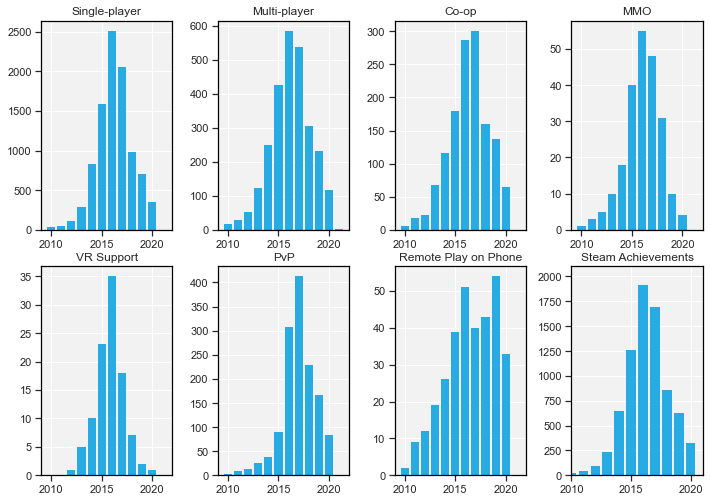

In [26]:
data["Year"] = data["Date"].dt.year
Cate_stat = data.pivot_table(index="Year",values=Category_Columns,aggfunc=sum).reset_index()[7:]

fig, ax = plt.subplots(2, 4, figsize=(10,7))
fig.tight_layout()

for i in range(8):
    if i <4:
        ax[0,i].bar("Year", Category_Columns[i], data=Cate_stat)
        ylim = Cate_stat[Category_Columns[i]].max()*1.1
        plt.xlim(2010, 2021)
        plt.ylim(0, ylim)
        ax[0,i].set_title(Category_Columns[i])
    else:
        ax[1,i-4].bar("Year", Category_Columns[i], data=Cate_stat)
        ylim = Cate_stat[Category_Columns[i]].max()*1.1
        plt.xlim(2010, 2021)
        plt.ylim(0, ylim)
        ax[1,i-4].set_title(Category_Columns[i])

plt.show()

Patterns showed by the categories of participation form of players are simillar and align with the trend of total games released. However, "Remote Play on Phone" game had a different pattern, keeping up with a steady expansion since 2016. This trend is supported by the popularity of mobile game market.

### Price

Prices of games are showing a discrete manner, usually set to be 9.99, 4.99, 14,99 and so on. Such prices are reasonable and familiar to players. The convention may also prevent price competitions among developers.

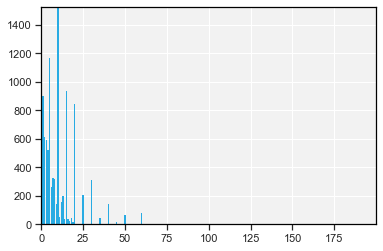

,Price,Count
0,9.99,1526
1,4.99,1166
2,14.99,935
3,0.99,897
4,19.99,844
...,...,...
57,1.20,1
58,2.79,1
59,28.99,1
60,45.00,1


In [27]:
## Price Distribution
Price_stat = pd.DataFrame(data["Final price"].astype(float).value_counts()).reset_index().rename(columns={"index":"Price","Final price":"Count"})

plt.xlim(0, Price_stat.Price.max())
plt.ylim(0, Price_stat.Count.max())
plt.bar("Price", "Count", data=Price_stat)
plt.show()

Price_stat

In [28]:
drop = len(data[data["Initial price"] > data["Final price"]]) # price drop
increase = len(data[data["Initial price"] < data["Final price"]]) # price increase
free = len(data[(data["Initial price"] != 0) & (data["Final price"] == 0)]) # made free

print("{} of games had a price drop, {} of game's prices increased and {} of games became free."\
     .format(drop,increase,free))
print("Only {:0.2f}% of games changed the price.".format((drop+increase)/len(data)*100))

0 of games had a price drop, 827 of game's prices increased and 0 of games became free.
Only 8.17% of games changed the price.


We avoided the sales season to collect our data in order to observe the original prices set by developers. As for changes in pricing, 8% of the games had increased their prices over time. The price comparison distribution is shown below:

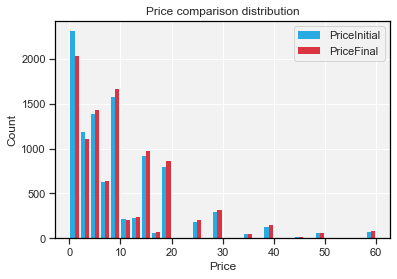

In [29]:
plt.hist([data["Initial price"], data["Final price"]], bins=30, range=(0,60), label=['PriceInitial', 'PriceFinal'])
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price comparison distribution')
plt.show()

### Correlation

Finally, let's have a look at the correlation between all our numerical attributes.It's also a nice part to get organised and conclude all the previous analysis of this project.

To answer the characteristics that make a favorable game, we analysed the distributions of recommendations on genre and developers. We also compared the propotions of categories of the total and the recommended subgroup. Combining these and the correlation chart, we believe that:
+ The participation form of players plays an important role to make the game attractive and playful. Action games are currently the most preferred type of game. There are also certain instrumental games(or apps) that has very good reputation
+ Recommended games usually has more developers and less genres
+ Players consider remote play on phones as a bonus when recommending games to others
+ 

However, drawing conclusions from statistical data and correlations may not be sufficient enough. Further steps of regression models and model training awaits. As our data is properly scaled and ready, it's possible to train a model and make predictions after we learn more about implications of machine learning.

In [30]:
for i in Unique_genre:
    data[i] = np.where(data["Genre"].str.contains(str(i), na=True),1,0)
    
Unique_genre = list(Unique_genre)
Unique_genre = list(filter(bool, Unique_genre))
numerical_columns = ["Recommendations","Genre Count","Developer Count"] + Unique_genre + Category_Columns
cm = sns.light_palette("green", as_cmap=True)
corr = data[numerical_columns].corr()
corr.style.background_gradient(cmap=cm)

,Recommendations,Genre Count,Developer Count,Action,Adventure,Strategy,Sports,Casual,Indie,Free to Play,Violent,Simulation,Racing,Audio Production,RPG,Sexual Content,Gore,Early Access,Short,Nudity,Animation & Modeling,Movie,Design & Illustration,Massively Multiplayer,Documentary,Utilities,Education,Photo Editing,Web Publishing,Episodic,Video Production,Software Training,Game Development,Single-player,Multi-player,Co-op,MMO,VR Support,PvP,Remote Play on Phone,Steam Achievements
Recommendations,1.000000,-0.019719,0.047057,0.029768,-0.008709,-0.009790,-0.004099,-0.039460,-0.057471,0.032844,-0.007237,0.002410,-0.003339,-0.001174,0.008125,-0.003410,-0.005765,-0.010249,-0.001049,-0.003397,0.015995,-0.002189,0.011077,0.030859,-0.001632,0.011205,-0.001484,0.020541,-0.000768,-0.001049,-0.000646,-0.000742,-0.001020,-0.066515,0.064683,0.050351,0.010249,-0.001822,0.034713,0.162827,0.010156
Genre Count,-0.019719,1.000000,-0.055715,0.257465,0.316535,0.274733,0.169218,0.287020,0.395444,0.220094,0.176360,0.322757,0.135559,0.002940,0.339014,0.089395,0.157206,0.282365,-0.020590,0.098406,0.022795,-0.021339,0.002140,0.276344,-0.019075,0.003672,0.003395,0.016784,0.000160,-0.014842,0.003395,-0.006431,0.025391,-0.115878,0.076399,0.099243,0.212656,-0.009251,0.108871,-0.038104,-0.029911
Developer Count,0.047057,-0.055715,1.000000,0.030450,-0.020677,0.015942,-0.003237,-0.038554,-0.119087,0.008968,-0.016770,-0.011676,-0.006279,0.021729,-0.002915,-0.020702,-0.007024,-0.024346,-0.004216,-0.020484,-0.002867,0.011183,0.023141,0.020971,0.011715,0.013731,-0.005963,-0.007890,0.034999,0.012252,-0.005963,-0.002981,-0.004216,-0.006886,0.047876,0.055699,0.013747,-0.000427,0.050238,0.068990,0.029925
Action,0.029768,0.257465,0.030450,1.000000,-0.023470,-0.185858,-0.002915,-0.183358,0.081973,0.014234,0.053470,-0.158527,0.044485,-0.016318,-0.038607,-0.051019,0.028894,0.059763,-0.013323,-0.026897,-0.031260,-0.025255,-0.042169,0.059904,-0.023081,-0.041099,-0.018844,-0.024932,-0.021069,-0.013323,-0.018844,-0.009420,-0.013323,-0.080190,0.230538,0.222551,0.024138,0.008393,0.149595,0.039808,0.039443
Adventure,-0.008709,0.316535,-0.020677,-0.023470,1.000000,-0.177295,-0.118457,0.005727,0.072737,-0.081833,0.029392,-0.110439,-0.083792,-0.014716,0.118063,0.002143,0.047485,-0.031661,-0.012015,0.009292,-0.028190,-0.022120,-0.038028,-0.015473,-0.020815,-0.037064,-0.016993,-0.022483,-0.019000,-0.012015,-0.016993,-0.008495,-0.012015,0.106193,-0.218013,-0.061514,-0.003038,-0.006941,-0.155084,0.016792,-0.001780
Strategy,-0.009790,0.274733,0.015942,-0.185858,-0.177295,1.000000,-0.005041,-0.031046,-0.010295,0.083721,-0.020807,0.188553,-0.065097,-0.008932,0.118467,-0.021737,-0.034134,0.039541,-0.007293,-0.024767,-0.017110,-0.009775,-0.023082,0.045116,-0.012634,-0.022496,-0.010314,-0.013646,-0.011532,-0.007293,-0.010314,-0.005156,-0.007293,-0.006503,0.101557,0.026919,0.028742,-0.018886,0.091946,-0.028182,0.014852
Sports,-0.004099,0.169218,-0.003237,-0.002915,-0.118457,-0.005041,1.000000,0.025123,-0.032977,0.024799,-0.006366,0.159495,0.279322,-0.003248,-0.070952,-0.013022,-0.011281,0.019759,-0.002652,-0.012885,-0.006223,-0.006223,-0.008394,0.018868,-0.004594,-0.008181,-0.003751,-0.004963,-0.004194,-0.002652,-0.003751,-0.001875,-0.002652,-0.020060,0.173799,0.040062,0.000595,0.007885,0.175818,0.013718,0.021465
Casual,-0.039460,0.287020,-0.038554,-0.183358,0.005727,-0.031046,0.025123,1.000000,0.086062,-0.020343,-0.026025,0.062207,-0.010976,-0.012186,-0.143672,0.045677,-0.016247,-0.033138,-0.009949,0.025617,-0.010627,-0.016985,-0.022055,-0.048547,-0.017236,-0.025851,-0.014072,-0.010649,-0.015733,-0.009949,-0.014072,-0.007035,-0.009949,0.076195,-0.135733,-0.096468,-0.058021,-0.032098,-0.061871,-0.040432,-0.044829
Indie,-0.057471,0.395444,-0.119087,0.081973,0.072737,-0.010295,-0.032977,0.086062,1.000000,-0.136058,0.013155,0.003538,-0.034824,-0.029077,-0.022720,-0.001771,0.024353,0.050289,-0.023740,-0.012594,-0.048861,-0.048861,-0.070066,-0.098014,-0.041127,-0.068028,-0.033577,-0.035853,-0.037542

### Acknowledgement

<i>At the end of this project, we want to sincerely thank Spencer, Chase and Professor Sargent for the excellent materials and inspiration throughout this semester. The skills we learned make us possible to do analysis project like this.</i>

<i>Wish you well and happy holidays.</i>